# PRIVATE DATASET INFERENCE NOTEBOOK - CLEAN VERSION

This notebook performs inference using trained models on the private dataset.

**Compatible with models trained in:**
- `training_private_DECEMBER_2024_baselines_CLEAN.ipynb`
- `training_private_DECEMBER_2024_venus_CLEAN.ipynb`

**FOCUS:** Private dataset ONLY - Individual tests clearly separated


## Setup and Imports


In [1]:
## Setup and Imports

import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
import pprint
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple, Optional
import sys

# PyTorch and related
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# MONAI imports
import monai
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Compose
)

# Backend imports
from breast_segmentation.config.settings import config
from breast_segmentation.utils.seed import set_deterministic_mode, seed_worker, reseed
from breast_segmentation.data.dataset import PairedDataset, PairedDataLoader
from breast_segmentation.transforms.compose import Preprocess
from breast_segmentation.metrics.evaluation import compute_dice_score, compute_iou
from breast_segmentation.models.lightning_module import BreastSegmentationModel
from breast_segmentation.models.fusion_module import BreastFusionModel

from breast_segmentation.data.private_dataset import (
    PATIENT_INFO, get_filenames, get_train_val_test_dicts, PATIENTS_TO_EXCLUDE,
    filter_samples_sample_aware, filter_samples_to_exclude, get_samples_size
)

from breast_segmentation.metrics.losses import (
    CABFL, SurfaceLossBinary, AsymmetricUnifiedFocalLoss, 
    AsymmetricFocalLoss, AsymmetricFocalTverskyLoss, SoftDiceLoss
)

from breast_segmentation.inference.private_dataset_aware_test import (
    test_dataset_aware_ensemble,
    test_dataset_aware_no_patches,
    test_dataset_aware_fusion
)


import time 
import os

# Set precision and print config
torch.set_float32_matmul_precision('medium')
print_config()

# Pretty printer for results
pp = pprint.PrettyPrinter(indent=4)

# Converter function for PIL images
def convert_to_grayscale(image):
    """Convert PIL image to grayscale - replaces lambda for pickling compatibility."""
    return image.convert("L")


# Register loss classes for checkpoint loading
sys.modules['__main__'].CABFL = CABFL
sys.modules['__main__'].SurfaceLossBinary = SurfaceLossBinary
sys.modules['__main__'].AsymmetricUnifiedFocalLoss = AsymmetricUnifiedFocalLoss
sys.modules['__main__'].AsymmetricFocalLoss = AsymmetricFocalLoss
sys.modules['__main__'].AsymmetricFocalTverskyLoss = AsymmetricFocalTverskyLoss


c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


MONAI version: 1.6.dev2535
Numpy version: 2.0.2
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8e677816bfd1fb2ec541d7f951db4caaf210b150
MONAI __file__: c:\Users\<username>\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED o

## Data Setup - Private Dataset


In [2]:
# Settings - using config parameters
NUM_WORKERS = config.NUM_WORKERS
SEED = config.SEED
USE_SUBTRACTED = True

# Data paths
dataset_base_path = config.DATASET_BASE_PATH_PRIVATE
CHECKPOINTS_DIR = config.checkpoints_dir_private

# Ensure checkpoint directory exists
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
print(f"Checkpoint directory verified: {CHECKPOINTS_DIR}")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Checkpoint directory verified: ./checkpoints/private-dataset
Using device: cuda


In [3]:
print("Using private dataset backend functions")

# Use patient IDs from PATIENT_INFO dictionary
patient_ids = os.listdir(dataset_base_path)

# Apply exclusions
print(f"Initial patients from PATIENT_INFO: {len(patient_ids)}")
print(f"Patients after exclusion: {len(patient_ids)}")


x_train_val, x_test = train_test_split(patient_ids, test_size=0.2, random_state=SEED)
x_train, x_val = train_test_split(x_train_val, test_size=0.25, random_state=SEED)

print(f"Dataset base path: {dataset_base_path}")
print(f"Total patients: {len(patient_ids)}")
print(f"Train patients: {len(x_train)}")
print(f"Validation patients: {len(x_val)}")
print(f"Test patients: {len(x_test)}")
print(f"Test patient IDs: {x_test}")


Using private dataset backend functions
Initial patients from PATIENT_INFO: 103
Patients after exclusion: 103
Dataset base path: Dataset-arrays-4-FINAL
Total patients: 103
Train patients: 61
Validation patients: 21
Test patients: 21
Test patient IDs: ['LAXXX', 'AS0170', 'PR0760', 'GF0380', 'FP211261', 'D2MP3(VR)', 'MG0477', 'OL1062R', 'BV1252', 'D1AP7(VR)', 'SD080569', 'CC0167', 'RHCL031174', 'LA0248', 'RP271052', 'SL191251', 'LGM0159(1,5)', 'PA150139', 'HF230274', 'CF160366', 'GLA1074']


##  Create Test Datasets


In [4]:
# Use subtracted images as in training
sub_third_images_path_prefixes = (config.DATASET_BASE_PATH_PRIVATE, "Dataset-arrays-FINAL")


mean_no_thorax_third_sub= 43.1498
std_no_thorax_third_sub= 172.6704
mean_patches_sub= 86.13536834716797
std_patches_sub= 238.13461303710938

# Create test transforms for global (no patches) data
test_transforms_no_thorax_third_sub = Compose([
    LoadImaged(
        keys=["image", "label"], 
        image_only=False, 
        reader=monai.data.NumpyReader()
    ),
    EnsureChannelFirstd(keys=["image", "label"]),
    Preprocess(
        keys=None, 
        mode='test',  
        dataset="private", 
        subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
        subtrahend=mean_no_thorax_third_sub, 
        divisor=std_no_thorax_third_sub, 
        get_patches=False,
        get_boundaryloss=True
    )
])

# Create test transforms for patches data
test_transforms_patches_sub = Compose([
    LoadImaged(
        keys=["image", "label"], 
        image_only=False, 
        reader=monai.data.NumpyReader()
    ),
    EnsureChannelFirstd(keys=["image", "label"]),
    Preprocess(
        keys=None, 
        mode='test',  
        dataset="private", 
        subtracted_images_path_prefixes=sub_third_images_path_prefixes, 
        subtrahend=mean_patches_sub, 
        divisor=std_patches_sub, 
        get_patches=True,
        get_boundaryloss=True
    )
])

print("Test transforms created")


Test transforms created


In [5]:
datasets = {}

for patient_id in x_test:
    print(patient_id)


    patient_id = [patient_id]
    images_fnames, _ = get_filenames(suffix="images",
                                       base_path=config.DATASET_BASE_PATH_PRIVATE,
                                       patient_ids=patient_id,
                                       remove_black_samples=False,
                                       get_random_samples_and_remove_black_samples=False,
                                       random_samples_indexes_list=None)

    labels_fnames, _ = get_filenames(suffix="masks",
                                      base_path=config.DATASET_BASE_PATH_PRIVATE,
                                      patient_ids=patient_id,
                                      remove_black_samples=False,
                                      get_random_samples_and_remove_black_samples=False,
                                      random_samples_indexes_list=None, remove_picked_samples=False)
    

    

    test_dicts = [{"image": image_name, "label":label_name} for image_name, label_name in zip(images_fnames,labels_fnames)]

    no_thorax_sub_test_ds = CacheDataset(data=test_dicts, transform=test_transforms_no_thorax_third_sub,num_workers=NUM_WORKERS)
    patches_sub_test_ds = CacheDataset(data=test_dicts, transform=test_transforms_patches_sub,num_workers=NUM_WORKERS)

    datasets[patient_id[0]]={
        "no_thorax_sub_test_ds": no_thorax_sub_test_ds,
        "patches_sub_test_ds": patches_sub_test_ds
        
    }

LAXXX


Loading dataset:   0%|          | 0/228 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 228/228 [00:23<00:00,  9.66it/s]


AS0170


Loading dataset: 100%|██████████| 192/192 [00:18<00:00, 10.24it/s]


PR0760


Loading dataset: 100%|██████████| 228/228 [00:25<00:00,  9.11it/s]


GF0380


Loading dataset: 100%|██████████| 204/204 [00:20<00:00,  9.73it/s]


FP211261


Loading dataset: 100%|██████████| 188/188 [00:18<00:00, 10.10it/s]


D2MP3(VR)


Loading dataset: 100%|██████████| 228/228 [00:23<00:00,  9.83it/s]


MG0477


Loading dataset: 100%|██████████| 132/132 [00:12<00:00, 10.31it/s]


OL1062R


Loading dataset: 100%|██████████| 228/228 [00:24<00:00,  9.33it/s]


BV1252


Loading dataset: 100%|██████████| 188/188 [00:19<00:00,  9.54it/s]


D1AP7(VR)


Loading dataset: 100%|██████████| 228/228 [00:22<00:00, 10.01it/s]


SD080569


Loading dataset: 100%|██████████| 236/236 [00:23<00:00,  9.95it/s]


CC0167


Loading dataset: 100%|██████████| 228/228 [00:21<00:00, 10.62it/s]


RHCL031174


Loading dataset: 100%|██████████| 188/188 [00:17<00:00, 10.62it/s]


LA0248


Loading dataset: 100%|██████████| 284/284 [00:29<00:00,  9.74it/s]


RP271052


Loading dataset: 100%|██████████| 96/96 [00:08<00:00, 10.89it/s]


SL191251


Loading dataset: 100%|██████████| 80/80 [00:07<00:00, 10.75it/s]


LGM0159(1,5)


Loading dataset: 100%|██████████| 112/112 [00:10<00:00, 10.69it/s]


PA150139


Loading dataset: 100%|██████████| 96/96 [00:08<00:00, 10.76it/s]


HF230274


Loading dataset: 100%|██████████| 204/204 [00:20<00:00,  9.85it/s]


CF160366


Loading dataset: 100%|██████████| 212/212 [00:21<00:00,  9.74it/s]


GLA1074


Loading dataset: 100%|██████████| 112/112 [00:10<00:00, 10.77it/s]


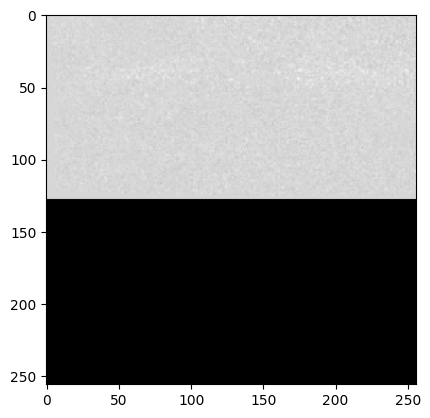

In [6]:
i = datasets[patient_id[0]]['patches_sub_test_ds'][104][0]['image']

plt.imshow(np.squeeze(i), cmap='gray')

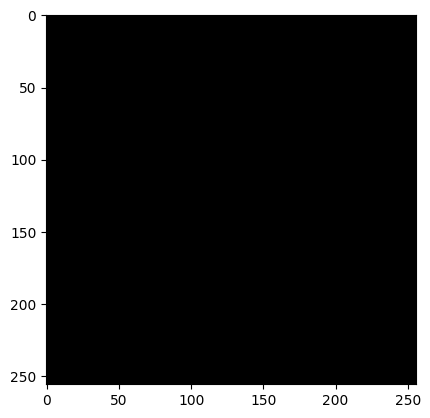

In [7]:
i = datasets[patient_id[0]]['patches_sub_test_ds'][104][0]['label']

plt.imshow(np.squeeze(i), cmap='gray')

## Model Checkpoint Paths


In [ ]:
model_paths = {
    # VENUS fusion models
    'venus_large': f'{CHECKPOINTS_DIR}/venus-large-best.ckpt',
    
    # Baseline models
    'unetplusplus': f'{CHECKPOINTS_DIR}/unetplusplus_model.ckpt',
    'skinny': f'{CHECKPOINTS_DIR}/skinny_model.ckpt',
    'resnet50': f'{CHECKPOINTS_DIR}/resnet50-model.ckpt',
    'fcn': f'{CHECKPOINTS_DIR}/fcn_ffnet_model.ckpt',  
    'segnet': f'{CHECKPOINTS_DIR}/segnet_model_large.ckpt',
    'swin': f'{CHECKPOINTS_DIR}/swin_model.ckpt',
    
    # Patches models
    'resnet18-patches':  f'{CHECKPOINTS_DIR}/resnet18-patches-model.ckpt'
}

# Check which models are available
print("Available models:")
for name, path in model_paths.items():
    if os.path.exists(path):
        print(f"  ✓ {name}: {path}")
    else:
        print(f"  ✗ {name}: {path} (not found)")


Available models:
  ✓ venus_large: ./checkpoints/private-dataset/venus-large-best.ckpt
  ✓ unetplusplus: ./checkpoints/private-dataset/unetplusplus_model.ckpt
  ✓ skinny: ./checkpoints/private-dataset/skinny_model.ckpt
  ✓ resnet50: ./checkpoints/private-dataset/resnet50-model.ckpt
  ✓ fcn: ./checkpoints/private-dataset/unetplusplus_model.ckpt
  ✓ segnet: ./checkpoints/private-dataset/segnet_model_large.ckpt
  ✓ swin: ./checkpoints/private-dataset/swin_model.ckpt
  ✓ resnet18-patches: ./checkpoints/private-dataset/resnet18-patches-model.ckpt


## Test Baseline Models


In [9]:
# Test baseline models (6 tests)
baseline_tests = [
    ('unetplusplus', 'UNet++', 'unetplusplus'),
    ('skinny', 'SkinnyNet', 'skinny') ,
    ('fcn', 'FCN', 'fcn_ffnet'), 
    ('segnet', 'SegNet', 'segnet'),
    ('swin', 'Swin-UNETR', 'swin_unetr'),
    ('resnet50', 'ResNet50', 'resnet50')
]

baseline_results = {}
for model_key, model_name, arch_name in baseline_tests:
    if os.path.exists(model_paths[model_key]):
        print(f"Testing {model_name} model...")
        result = test_dataset_aware_no_patches(
            model_path=model_paths[model_key],
            patient_ids=x_test,
            datasets=datasets,
            dataset_key="no_thorax_sub_test_ds",
            filter=False,
            get_scores_for_statistics=False,
            get_only_masses=False,
            arch_name=arch_name,
            strict=True,
            subtracted=True
        )
        baseline_results[model_key] = result
        print(f"\n{model_name} Results:")
        pp.pprint(result)
    else:
        print(f"{model_paths[model_key]} not found.")
        baseline_results[model_key] = None

print(f"\nCompleted {len([r for r in baseline_results.values() if r is not None])} baseline model tests.")


Testing UNet++ model...
BasicUNetPlusPlus features: (32, 32, 64, 128, 256, 32).
LAXXX


100%|██████████| 228/228 [00:05<00:00, 42.25it/s] 


AS0170


100%|██████████| 192/192 [00:06<00:00, 31.56it/s]


PR0760


100%|██████████| 228/228 [00:05<00:00, 43.87it/s] 


GF0380


100%|██████████| 204/204 [00:04<00:00, 49.01it/s]


FP211261


100%|██████████| 188/188 [00:02<00:00, 72.89it/s]


D2MP3(VR)


100%|██████████| 228/228 [00:04<00:00, 45.91it/s] 


MG0477


100%|██████████| 132/132 [00:03<00:00, 43.93it/s]


OL1062R


100%|██████████| 228/228 [00:05<00:00, 45.25it/s] 


BV1252


100%|██████████| 188/188 [00:03<00:00, 50.53it/s]


D1AP7(VR)


100%|██████████| 228/228 [00:04<00:00, 47.48it/s] 


SD080569


100%|██████████| 236/236 [00:03<00:00, 59.40it/s] 


CC0167


100%|██████████| 228/228 [00:03<00:00, 58.26it/s] 


RHCL031174


100%|██████████| 188/188 [00:05<00:00, 36.03it/s]


LA0248


100%|██████████| 284/284 [00:06<00:00, 46.92it/s]


RP271052


100%|██████████| 96/96 [00:01<00:00, 49.27it/s]


SL191251


100%|██████████| 80/80 [00:01<00:00, 43.54it/s] 


LGM0159(1,5)


100%|██████████| 112/112 [00:02<00:00, 49.77it/s]


PA150139


100%|██████████| 96/96 [00:01<00:00, 49.68it/s] 


HF230274


100%|██████████| 204/204 [00:04<00:00, 50.22it/s] 


CF160366


100%|██████████| 212/212 [00:04<00:00, 46.84it/s] 


GLA1074


100%|██████████| 112/112 [00:03<00:00, 37.03it/s]


MODEL CLASS MEAN IOU  0.5861474
MODEL CLASS STD IOU  0.14819752

MODEL CLASS MEAN DICE  0.603638
MODEL CLASS STD DICE  0.17330746

MODEL DIOU 0.8241011885329741
MODEL DIOU STD  0.29988049988069254

MODEL IOU MASS VOLUME  0.5594797730445862
MODEL IOU MASS VOLUME STD  0.46604278683662415

MODEL IOU MASS VOLUME NO EMPTY  0.17293545603752136
MODEL IOU MASS VOLUME NO EMPTY STD  0.2966097891330719

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.5810295343399048
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2418101578950882
MODEL DICE MASS VOLUME  0.5779414176940918
MODEL DICE MASS VOLUME STD  0.4694083631038666

MODEL DICE MASS VOLUME NO EMPTY  0.20759660005569458
MODEL DICE MASS VOLUME NO EMPTY STD  0.34673863649368286

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.6974841952323914
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2495051920413971

MODEL MEAN ACCURACY NO EMPTY 0.5862971395254135
MODEL MEAN ACCURACY NO EMPTY STD 0.1487303

MODEL MEAN PRECISION NO EMPTY 0.6108993589878082
MO

100%|██████████| 228/228 [00:05<00:00, 41.43it/s] 


AS0170


100%|██████████| 192/192 [00:05<00:00, 34.53it/s]


PR0760


100%|██████████| 228/228 [00:04<00:00, 47.32it/s] 


GF0380


100%|██████████| 204/204 [00:03<00:00, 54.89it/s] 


FP211261


100%|██████████| 188/188 [00:02<00:00, 81.39it/s]


D2MP3(VR)


100%|██████████| 228/228 [00:04<00:00, 49.37it/s] 


MG0477


100%|██████████| 132/132 [00:02<00:00, 46.25it/s]


OL1062R


100%|██████████| 228/228 [00:04<00:00, 48.64it/s] 


BV1252


100%|██████████| 188/188 [00:03<00:00, 55.65it/s] 


D1AP7(VR)


100%|██████████| 228/228 [00:03<00:00, 60.04it/s] 


SD080569


100%|██████████| 236/236 [00:03<00:00, 66.95it/s] 


CC0167


100%|██████████| 228/228 [00:03<00:00, 62.80it/s] 


RHCL031174


100%|██████████| 188/188 [00:04<00:00, 39.00it/s]


LA0248


100%|██████████| 284/284 [00:05<00:00, 53.92it/s]


RP271052


100%|██████████| 96/96 [00:02<00:00, 45.22it/s]


SL191251


100%|██████████| 80/80 [00:01<00:00, 44.72it/s] 


LGM0159(1,5)


100%|██████████| 112/112 [00:02<00:00, 52.97it/s]


PA150139


100%|██████████| 96/96 [00:01<00:00, 55.25it/s] 


HF230274


100%|██████████| 204/204 [00:03<00:00, 56.39it/s] 


CF160366


100%|██████████| 212/212 [00:04<00:00, 50.99it/s] 


GLA1074


100%|██████████| 112/112 [00:02<00:00, 40.86it/s]


MODEL CLASS MEAN IOU  0.59041554
MODEL CLASS STD IOU  0.14975789

MODEL CLASS MEAN DICE  0.6091392
MODEL CLASS STD DICE  0.17559198

MODEL DIOU 0.7936827036693562
MODEL DIOU STD  0.3156589441909492

MODEL IOU MASS VOLUME  0.5905802845954895
MODEL IOU MASS VOLUME STD  0.4609158933162689

MODEL IOU MASS VOLUME NO EMPTY  0.18158115446567535
MODEL IOU MASS VOLUME NO EMPTY STD  0.29971152544021606

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.5729959607124329
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.24326558411121368
MODEL DICE MASS VOLUME  0.609126091003418
MODEL DICE MASS VOLUME STD  0.46299389004707336

MODEL DICE MASS VOLUME NO EMPTY  0.2186538279056549
MODEL DICE MASS VOLUME NO EMPTY STD  0.35130101442337036

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.6899821758270264
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2534383237361908

MODEL MEAN ACCURACY NO EMPTY 0.590602919459343
MODEL MEAN ACCURACY NO EMPTY STD 0.15027712

MODEL MEAN PRECISION NO EMPTY 0.6124514862895012
M

100%|██████████| 228/228 [00:05<00:00, 43.44it/s] 


AS0170


100%|██████████| 192/192 [00:06<00:00, 31.99it/s]


PR0760


100%|██████████| 228/228 [00:05<00:00, 43.55it/s] 


GF0380


100%|██████████| 204/204 [00:04<00:00, 48.24it/s]


FP211261


100%|██████████| 188/188 [00:02<00:00, 76.51it/s]


D2MP3(VR)


100%|██████████| 228/228 [00:04<00:00, 45.68it/s] 


MG0477


100%|██████████| 132/132 [00:03<00:00, 42.13it/s]


OL1062R


100%|██████████| 228/228 [00:04<00:00, 45.82it/s] 


BV1252


100%|██████████| 188/188 [00:03<00:00, 50.12it/s] 


D1AP7(VR)


100%|██████████| 228/228 [00:04<00:00, 48.77it/s] 


SD080569


100%|██████████| 236/236 [00:03<00:00, 59.90it/s] 


CC0167


100%|██████████| 228/228 [00:03<00:00, 59.12it/s] 


RHCL031174


100%|██████████| 188/188 [00:05<00:00, 35.39it/s]


LA0248


100%|██████████| 284/284 [00:06<00:00, 46.67it/s]


RP271052


100%|██████████| 96/96 [00:02<00:00, 47.13it/s]


SL191251


100%|██████████| 80/80 [00:01<00:00, 42.98it/s] 


LGM0159(1,5)


100%|██████████| 112/112 [00:02<00:00, 46.04it/s]


PA150139


100%|██████████| 96/96 [00:02<00:00, 46.83it/s] 


HF230274


100%|██████████| 204/204 [00:04<00:00, 50.38it/s] 


CF160366


100%|██████████| 212/212 [00:04<00:00, 47.48it/s] 


GLA1074


100%|██████████| 112/112 [00:02<00:00, 37.88it/s]


MODEL CLASS MEAN IOU  0.5861474
MODEL CLASS STD IOU  0.14819752

MODEL CLASS MEAN DICE  0.603638
MODEL CLASS STD DICE  0.17330746

MODEL DIOU 0.8241011885329741
MODEL DIOU STD  0.29988049988069254

MODEL IOU MASS VOLUME  0.5594797730445862
MODEL IOU MASS VOLUME STD  0.46604278683662415

MODEL IOU MASS VOLUME NO EMPTY  0.17293545603752136
MODEL IOU MASS VOLUME NO EMPTY STD  0.2966097891330719

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.5810295343399048
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2418101578950882
MODEL DICE MASS VOLUME  0.5779414176940918
MODEL DICE MASS VOLUME STD  0.4694083631038666

MODEL DICE MASS VOLUME NO EMPTY  0.20759660005569458
MODEL DICE MASS VOLUME NO EMPTY STD  0.34673863649368286

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.6974841952323914
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2495051920413971

MODEL MEAN ACCURACY NO EMPTY 0.5862971395254135
MODEL MEAN ACCURACY NO EMPTY STD 0.1487303

MODEL MEAN PRECISION NO EMPTY 0.6108993589878082
MO

100%|██████████| 228/228 [00:04<00:00, 48.67it/s] 


AS0170


100%|██████████| 192/192 [00:05<00:00, 36.05it/s]


PR0760


100%|██████████| 228/228 [00:04<00:00, 46.02it/s] 


GF0380


100%|██████████| 204/204 [00:03<00:00, 54.24it/s]


FP211261


100%|██████████| 188/188 [00:01<00:00, 96.85it/s] 


D2MP3(VR)


100%|██████████| 228/228 [00:04<00:00, 52.62it/s] 


MG0477


100%|██████████| 132/132 [00:02<00:00, 47.02it/s]


OL1062R


100%|██████████| 228/228 [00:04<00:00, 52.81it/s] 


BV1252


100%|██████████| 188/188 [00:03<00:00, 55.56it/s] 


D1AP7(VR)


100%|██████████| 228/228 [00:03<00:00, 57.84it/s] 


SD080569


100%|██████████| 236/236 [00:03<00:00, 65.45it/s] 


CC0167


100%|██████████| 228/228 [00:03<00:00, 62.67it/s] 


RHCL031174


100%|██████████| 188/188 [00:04<00:00, 41.04it/s]


LA0248


100%|██████████| 284/284 [00:05<00:00, 56.64it/s] 


RP271052


100%|██████████| 96/96 [00:01<00:00, 54.86it/s]


SL191251


100%|██████████| 80/80 [00:01<00:00, 54.89it/s]


LGM0159(1,5)


100%|██████████| 112/112 [00:01<00:00, 68.06it/s]


PA150139


100%|██████████| 96/96 [00:01<00:00, 62.23it/s] 


HF230274


100%|██████████| 204/204 [00:03<00:00, 64.40it/s] 


CF160366


100%|██████████| 212/212 [00:03<00:00, 60.47it/s] 


GLA1074


100%|██████████| 112/112 [00:02<00:00, 48.12it/s]


MODEL CLASS MEAN IOU  0.5841027
MODEL CLASS STD IOU  0.14451143

MODEL CLASS MEAN DICE  0.6023463
MODEL CLASS STD DICE  0.17039889

MODEL DIOU 0.7599096539629479
MODEL DIOU STD  0.329311818890917

MODEL IOU MASS VOLUME  0.5851070284843445
MODEL IOU MASS VOLUME STD  0.4631313681602478

MODEL IOU MASS VOLUME NO EMPTY  0.16893284022808075
MODEL IOU MASS VOLUME NO EMPTY STD  0.28924834728240967

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.5319878458976746
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.2651943564414978
MODEL DICE MASS VOLUME  0.6031412482261658
MODEL DICE MASS VOLUME STD  0.46477022767066956

MODEL DICE MASS VOLUME NO EMPTY  0.20505690574645996
MODEL DICE MASS VOLUME NO EMPTY STD  0.3409331738948822

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.6457464694976807
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.28541940450668335

MODEL MEAN ACCURACY NO EMPTY 0.5842848345637321
MODEL MEAN ACCURACY NO EMPTY STD 0.14510562

MODEL MEAN PRECISION NO EMPTY 0.6128269508481026
M

100%|██████████| 228/228 [00:10<00:00, 22.08it/s]


AS0170


100%|██████████| 192/192 [00:10<00:00, 17.61it/s]


PR0760


100%|██████████| 228/228 [00:10<00:00, 21.11it/s] 


GF0380


100%|██████████| 204/204 [00:08<00:00, 23.35it/s]


FP211261


100%|██████████| 188/188 [00:04<00:00, 40.72it/s]


D2MP3(VR)


100%|██████████| 228/228 [00:10<00:00, 22.06it/s]


MG0477


100%|██████████| 132/132 [00:05<00:00, 23.57it/s]


OL1062R


100%|██████████| 228/228 [00:09<00:00, 24.07it/s] 


BV1252


100%|██████████| 188/188 [00:08<00:00, 22.86it/s]


D1AP7(VR)


100%|██████████| 228/228 [00:08<00:00, 27.07it/s] 


SD080569


100%|██████████| 236/236 [00:07<00:00, 31.99it/s] 


CC0167


100%|██████████| 228/228 [00:07<00:00, 30.91it/s]


RHCL031174


100%|██████████| 188/188 [00:09<00:00, 19.11it/s]


LA0248


100%|██████████| 284/284 [00:12<00:00, 23.39it/s]


RP271052


100%|██████████| 96/96 [00:03<00:00, 25.24it/s]


SL191251


100%|██████████| 80/80 [00:03<00:00, 24.58it/s]


LGM0159(1,5)


100%|██████████| 112/112 [00:04<00:00, 27.26it/s]


PA150139


100%|██████████| 96/96 [00:03<00:00, 27.75it/s] 


HF230274


100%|██████████| 204/204 [00:07<00:00, 26.05it/s]


CF160366


100%|██████████| 212/212 [00:08<00:00, 24.91it/s]


GLA1074


100%|██████████| 112/112 [00:05<00:00, 21.58it/s]


MODEL CLASS MEAN IOU  0.61077195
MODEL CLASS STD IOU  0.16354942

MODEL CLASS MEAN DICE  0.63151956
MODEL CLASS STD DICE  0.1884164

MODEL DIOU 0.8711695413621241
MODEL DIOU STD  0.26683839405871324

MODEL IOU MASS VOLUME  0.6665460467338562
MODEL IOU MASS VOLUME STD  0.44053301215171814

MODEL IOU MASS VOLUME NO EMPTY  0.2224070429801941
MODEL IOU MASS VOLUME NO EMPTY STD  0.3272329866886139

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.6016164422035217
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.24803076684474945
MODEL DICE MASS VOLUME  0.6841555237770081
MODEL DICE MASS VOLUME STD  0.44022199511528015

MODEL DICE MASS VOLUME NO EMPTY  0.2634713649749756
MODEL DICE MASS VOLUME NO EMPTY STD  0.3769248127937317

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.7126964330673218
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.25327450037002563

MODEL MEAN ACCURACY NO EMPTY 0.6110184490680695
MODEL MEAN ACCURACY NO EMPTY STD 0.16412672

MODEL MEAN PRECISION NO EMPTY 0.6345871239900589

100%|██████████| 228/228 [00:06<00:00, 35.71it/s] 


AS0170


100%|██████████| 192/192 [00:07<00:00, 26.85it/s]


PR0760


100%|██████████| 228/228 [00:05<00:00, 41.08it/s] 


GF0380


100%|██████████| 204/204 [00:04<00:00, 47.85it/s]


FP211261


100%|██████████| 188/188 [00:02<00:00, 72.17it/s]


D2MP3(VR)


100%|██████████| 228/228 [00:05<00:00, 40.73it/s]


MG0477


100%|██████████| 132/132 [00:03<00:00, 37.02it/s]


OL1062R


100%|██████████| 228/228 [00:05<00:00, 43.87it/s] 


BV1252


100%|██████████| 188/188 [00:03<00:00, 47.76it/s]


D1AP7(VR)


100%|██████████| 228/228 [00:05<00:00, 43.54it/s] 


SD080569


100%|██████████| 236/236 [00:04<00:00, 55.77it/s] 


CC0167


100%|██████████| 228/228 [00:04<00:00, 55.28it/s] 


RHCL031174


100%|██████████| 188/188 [00:05<00:00, 32.99it/s]


LA0248


100%|██████████| 284/284 [00:06<00:00, 44.35it/s]


RP271052


100%|██████████| 96/96 [00:01<00:00, 49.71it/s]


SL191251


100%|██████████| 80/80 [00:01<00:00, 41.32it/s] 


LGM0159(1,5)


100%|██████████| 112/112 [00:02<00:00, 44.05it/s]


PA150139


100%|██████████| 96/96 [00:02<00:00, 46.71it/s] 


HF230274


100%|██████████| 204/204 [00:04<00:00, 43.72it/s] 


CF160366


100%|██████████| 212/212 [00:04<00:00, 51.34it/s] 


GLA1074


100%|██████████| 112/112 [00:03<00:00, 36.14it/s]


MODEL CLASS MEAN IOU  0.6541247
MODEL CLASS STD IOU  0.16112953

MODEL CLASS MEAN DICE  0.69052994
MODEL CLASS STD DICE  0.18732928

MODEL DIOU 0.48139805449367845
MODEL DIOU STD  0.4263533941207131

MODEL IOU MASS VOLUME  0.8684301972389221
MODEL IOU MASS VOLUME STD  0.3053703308105469

MODEL IOU MASS VOLUME NO EMPTY  0.3098789155483246
MODEL IOU MASS VOLUME NO EMPTY STD  0.3217676877975464

MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC  0.37265825271606445
MODEL IOU MASS VOLUME NO EMPTY OPTIMISTIC STD  0.3179851770401001
MODEL DICE MASS VOLUME  0.8821564316749573
MODEL DICE MASS VOLUME STD  0.2927244305610657

MODEL DICE MASS VOLUME NO EMPTY  0.3818768262863159
MODEL DICE MASS VOLUME NO EMPTY STD  0.37446126341819763

MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC  0.45924246311187744
MODEL DICE MASS VOLUME NO EMPTY OPTIMISTIC STD  0.36482805013656616

MODEL MEAN ACCURACY NO EMPTY 0.654784083366394
MODEL MEAN ACCURACY NO EMPTY STD 0.16150318

MODEL MEAN PRECISION NO EMPTY 0.8328231573104858


## Test VENUS Model


In [14]:
# Test 1: venus-large-best.ckpt
if os.path.exists(model_paths['venus_large']): 
    print("Testing VENUS Large ...")
    scores_for_statistics_fusion_large2 = test_dataset_aware_fusion(
        model_path=model_paths['venus_large'],
        patient_ids=x_test,
        datasets=datasets,
        whole_dataset_key="no_thorax_sub_test_ds",
        patches_dataset_key="patches_sub_test_ds",
        use_simple_fusion=True,
        use_decoder_attention=True,
        strict=True,
        filter=False,
        subtracted=True,
        get_scores_for_statistics=False,
        get_only_masses=False,
        base_channels=64
    )
    print("\nVENUS Large:")
    pp.pprint(scores_for_statistics_fusion_large2)
else:
    print("venus-large.ckpt not found.")
    scores_for_statistics_fusion_large2 = None

Testing VENUS Large ...


c:\Users\pabli\AppData\Local\pypoetry\Cache\virtualenvs\venus-nCPuPPcI-py3.9\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 't_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['t_loss'])`.


RuntimeError: Error(s) in loading state_dict for BreastFusionModel:
	Unexpected key(s) in state_dict: "model.fusion_skip1.channel_attention_local.fc1.weight", "model.fusion_skip1.channel_attention_local.fc2.weight", "model.fusion_skip1.spatial_attention_local.conv.weight", "model.fusion_skip1.spatial_attention_local.conv.bias", "model.fusion_skip1.channel_attention_global.fc1.weight", "model.fusion_skip1.channel_attention_global.fc2.weight", "model.fusion_skip1.spatial_attention_global.conv.weight", "model.fusion_skip1.spatial_attention_global.conv.bias", "model.fusion_skip2.channel_attention_local.fc1.weight", "model.fusion_skip2.channel_attention_local.fc2.weight", "model.fusion_skip2.spatial_attention_local.conv.weight", "model.fusion_skip2.spatial_attention_local.conv.bias", "model.fusion_skip2.channel_attention_global.fc1.weight", "model.fusion_skip2.channel_attention_global.fc2.weight", "model.fusion_skip2.spatial_attention_global.conv.weight", "model.fusion_skip2.spatial_attention_global.conv.bias", "model.fusion_skip3.channel_attention_local.fc1.weight", "model.fusion_skip3.channel_attention_local.fc2.weight", "model.fusion_skip3.spatial_attention_local.conv.weight", "model.fusion_skip3.spatial_attention_local.conv.bias", "model.fusion_skip3.channel_attention_global.fc1.weight", "model.fusion_skip3.channel_attention_global.fc2.weight", "model.fusion_skip3.spatial_attention_global.conv.weight", "model.fusion_skip3.spatial_attention_global.conv.bias", "model.fusion_skip4.channel_attention_local.fc1.weight", "model.fusion_skip4.channel_attention_local.fc2.weight", "model.fusion_skip4.spatial_attention_local.conv.weight", "model.fusion_skip4.spatial_attention_local.conv.bias", "model.fusion_skip4.channel_attention_global.fc1.weight", "model.fusion_skip4.channel_attention_global.fc2.weight", "model.fusion_skip4.spatial_attention_global.conv.weight", "model.fusion_skip4.spatial_attention_global.conv.bias", "model.deep_feature_fusion.channel_attention_local.fc1.weight", "model.deep_feature_fusion.channel_attention_local.fc2.weight", "model.deep_feature_fusion.spatial_attention_local.conv.weight", "model.deep_feature_fusion.spatial_attention_local.conv.bias", "model.deep_feature_fusion.channel_attention_global.fc1.weight", "model.deep_feature_fusion.channel_attention_global.fc2.weight", "model.deep_feature_fusion.spatial_attention_global.conv.weight", "model.deep_feature_fusion.spatial_attention_global.conv.bias". 

## Test Ensemble Model


In [ ]:
ensemble_tests = [

    ('venus_large', 'resnet18-patches', False, 64, 'VENUS Large + ResNet18 patches'),
    ('venus_large', 'resnet18-patches', True, 64, 'VENUS Large + ResNet18 patches (filtered)'),
]


ensemble_results = {}
for whole_key, patches_key, use_filter, base_channels, description in ensemble_tests:
    if os.path.exists(model_paths[whole_key]) and os.path.exists(model_paths[patches_key]):
        print(f"Testing Ensemble: {description}...")
        
        result = test_dataset_aware_ensemble(
            model_whole_path=model_paths[whole_key],
            model_patches_path=model_paths[patches_key],
            patient_ids=x_test,
            datasets=datasets,
            whole_dataset_key="no_thorax_sub_test_ds",
            patches_dataset_key="patches_sub_test_ds",
            filter=use_filter,
            get_scores_for_statistics=False,
            get_only_masses=False,
            subtracted=True,
            base_channels=base_channels,
            use_decoder_attention = True,
            use_simple_fusion = True
        )
        
        ensemble_key = f"{whole_key}+{patches_key}{'_filtered' if use_filter else ''}"
        ensemble_results[ensemble_key] = result
        print(f"\n{description} Results:")
        pp.pprint(result)
    else:
        print(f"Required models not found for ensemble: {description}")
        ensemble_key = f"{whole_key}+{patches_key}{'_filtered' if use_filter else ''}"
        ensemble_results[ensemble_key] = None

print(f"\nCompleted {len([r for r in ensemble_results.values() if r is not None])} ensemble model tests.")


Required models not found for ensemble: VENUS Large + ResNet18 patches
Required models not found for ensemble: VENUS Large + ResNet18 patches (filtered)

Completed 0 ensemble model tests.
